# Principal Component Analysis

```
Dustin Michels
Nov 2017
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

from sklearn.decomposition import PCA
from scipy import stats

## Load Data

In [2]:
# This set the level of taxonomic analysis
TAXON_LVL = 3

# This runs the data_cleaning jupyter notebook,
# giving us accessing to variables created over there.
%run load_data.ipynb

In [3]:
# This is for storing images in the right folder
lvl = f"lvl{TAXON_LVL}"
lvl

'lvl3'

In [4]:
# Load approporate DFs, using newly loaded vars/ fcns

go_df = get_top_n(full_go, by_col='read_percent', n=25)
go_df = truncate_names(go_df)
tax_df = get_top_n(full_tax, by_col='tax_percent', n=10)

## Define Functions PCA / Plotting

In [5]:
def make_pca_df(data_df, vals='read_percent'):
    df = data_df.pivot(
        index='run_id', columns='name', values=vals)
    df.sort_index()
    return df

def do_PCA(pca_df, n=2):
    data = pca_df.as_matrix()
    pca = PCA(n_components=n)    
    pca_array = pca.fit_transform(data)
    return pca, pca_array
    
def make_plot_df(pca_array):
    # Add data to new DF, with metadata
    df = meta_df.set_index('run_id')
    df.sort_index(inplace=True)
    for i in range(pca_array.shape[1]):
        df.insert(i, f'PC{i+1}', pca_array[:,i])
    
    # Tidy up DF
    df['region'] = df['region'].map(region_map)
    df['zone'] = df['zone'].map(zone_map)
    df = df.drop('filename', axis=1)
    df.reset_index(inplace=True)    
    return df

def make_pca_plot(data, hue='region', filename='my_pca_plot'):
    
    g = sns.lmplot(
        'PC1','PC2', data=data,
        fit_reg=False, hue=hue)
    g.savefig(f'{img_path}pca/{filename}.png')

## Make Plots of PC1 vs. PC2

### GO

[  5.94034888e-05   5.51433168e-06]


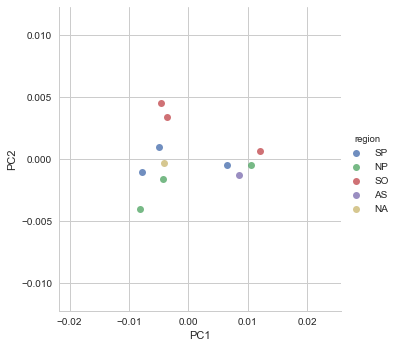

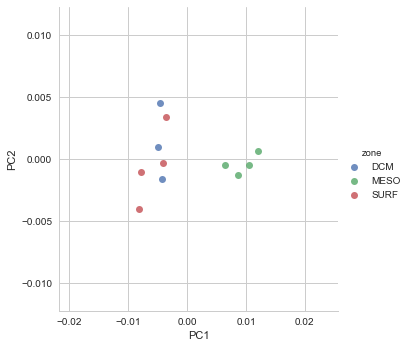

In [6]:
go_pca_df = make_pca_df(go_df, vals='read_percent')
pca, pca_array = do_PCA(go_pca_df, n=2)
go_plot_df = make_plot_df(pca_array)

# print variance explained by each axis
print(pca.explained_variance_)

# hue = region
make_pca_plot(
    go_plot_df, hue='region',
    filename='go/pca_go_region')

# hue = zone
make_pca_plot(
    go_plot_df, hue='zone',
    filename='go/pca_go_zone')

### Taxonomy

[ 0.01492756  0.0117479 ]


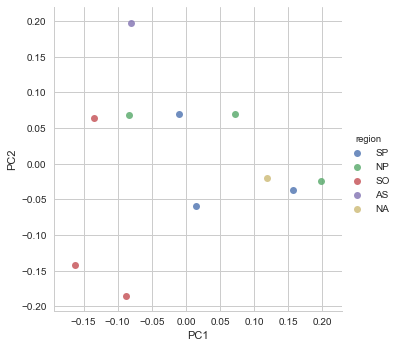

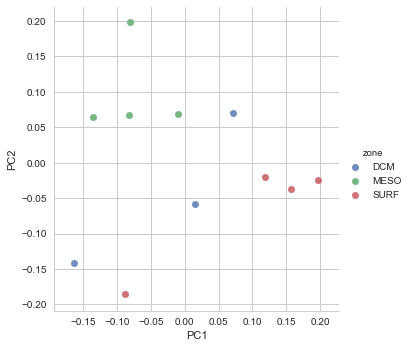

In [7]:
tax_pca_df = make_pca_df(tax_df, vals='tax_percent')
pca, pca_array = do_PCA(tax_pca_df, n=2)
tax_plot_df = make_plot_df(pca_array)

# print variance explained by each axis
print(pca.explained_variance_)

# hue = region
make_pca_plot(
    tax_plot_df, hue='region',
    filename=f'tax/{lvl}/pca_tax_region')

# hue = zone
make_pca_plot(
    tax_plot_df, hue='zone',
    filename=f'tax/{lvl}/pca_tax_zone')

## Joint Plots

### Define Functions

In [8]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [9]:
def make_jointplot(df, y_val='depth_(m)', filename='my_jointplot'):
    f = sns.jointplot(
        x='PC1', y=y_val, data=df,
        kind='reg', stat_func=r2)
    f.savefig(
        f'{img_path}pca-joint/{filename}',
        bbox_inches='tight', dpi=250)

In [10]:
# copy each item in list, remove lat and long
categories = meta_headers[:]
categories.remove('lat')
categories.remove('long')

### GO

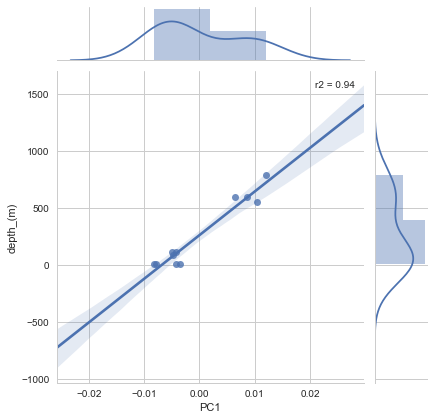

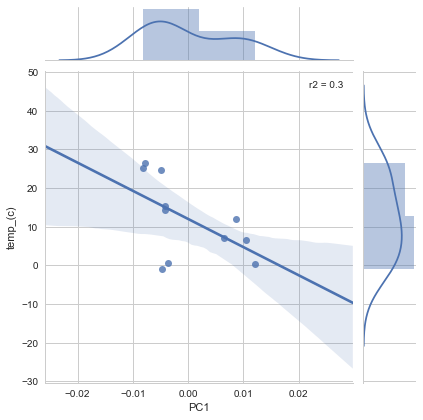

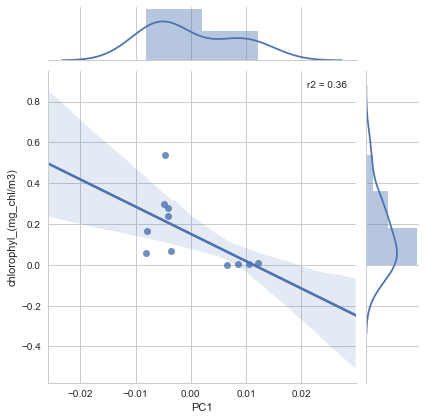

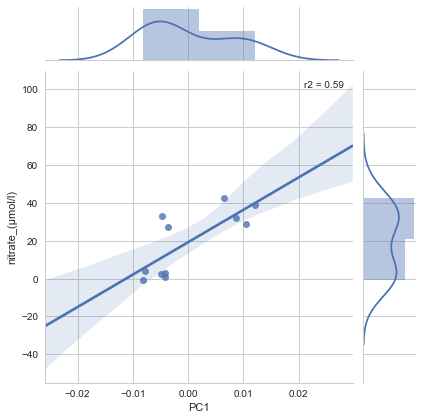

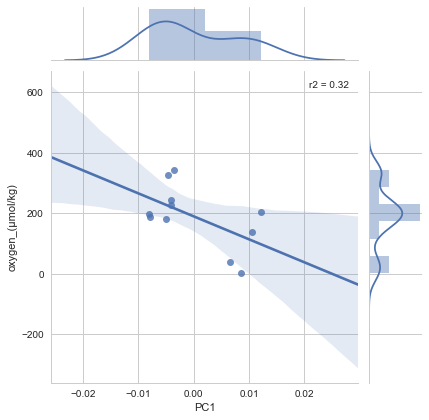

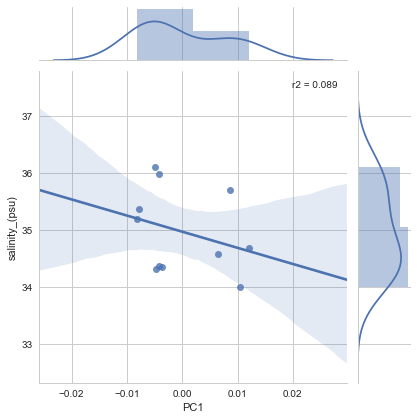

In [11]:
for val in categories:
    
    # grab part of word b/f first underscore
    name = val[:val.find('_')]
    
    make_jointplot(
        go_plot_df, y_val=val,
        filename=f'go/joint_go_PC_vs_{name}')

### Taxonomy

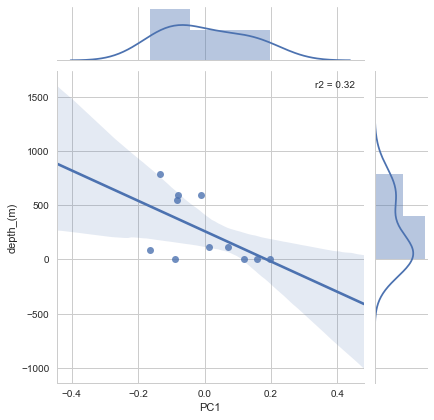

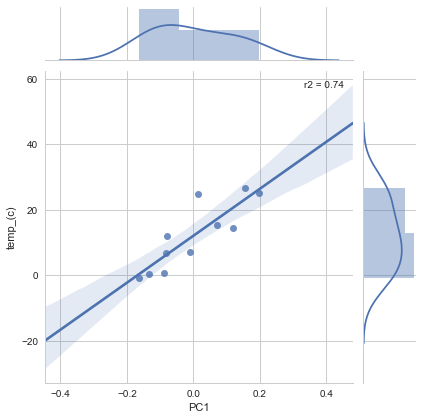

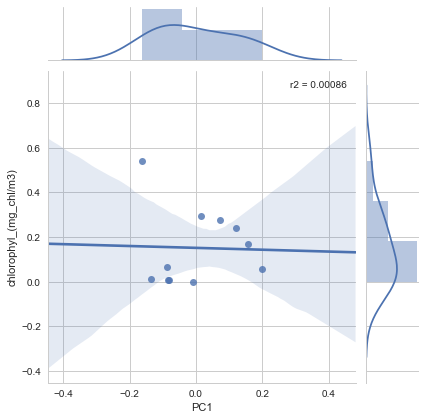

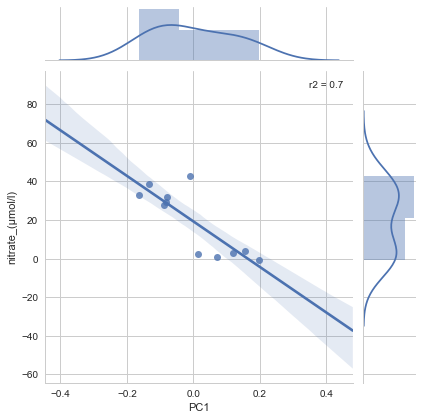

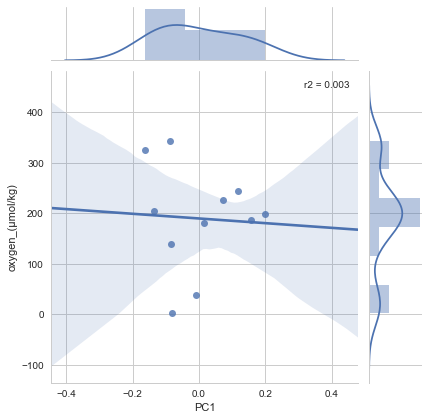

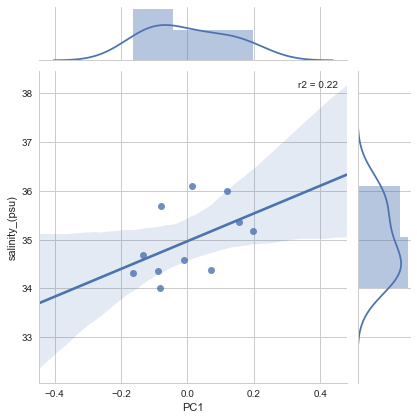

In [12]:
for val in categories:
    
    # grab part of word b/f first underscore
    name = val[:val.find('_')]
    
    make_jointplot(
        tax_plot_df, y_val=val,
        filename=f'tax/{lvl}/joint_tax_PC_vs_{name}')

## Pairplot

In [13]:
# Make new DF, dropping some values

drop_vals = [
    'run_id', 'filename', 'lat', 'long',
    'chlorophyl_(mg_chl/m3)']

meta = meta_df.drop(drop_vals, axis=1)
meta['zone'] = meta['zone'].map(zone_map)
meta['region'] = meta['region'].map(region_map)

In [14]:
meta

,region,zone,depth_(m),temp_(c),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu)
0,SO,DCM,90,-0.781540,33.109231,325.402987,34.319478
1,SO,SURF,5,0.671080,27.501159,343.437300,34.353880
2,SO,MESO,790,0.458830,38.821249,203.839400,34.679960
3,SP,DCM,115,24.696250,2.333576,179.916875,36.097575
4,SP,SURF,5,26.544130,3.986359,186.240700,35.366200
5,SP,MESO,600,7.212238,42.532050,38.115125,34.580675
6,NP,DCM,115,15.284298,0.732507,225.501338,34.369090
7,NP,MESO,550,6.689724,29.094100,138.735952,34.000507
8,NP,SURF,5,25.173925,-0.979589,197.682417,35.181842
9,NA,SURF,5,14.280650,2.999226,243.148000,35.986042


### Regression Pairplot

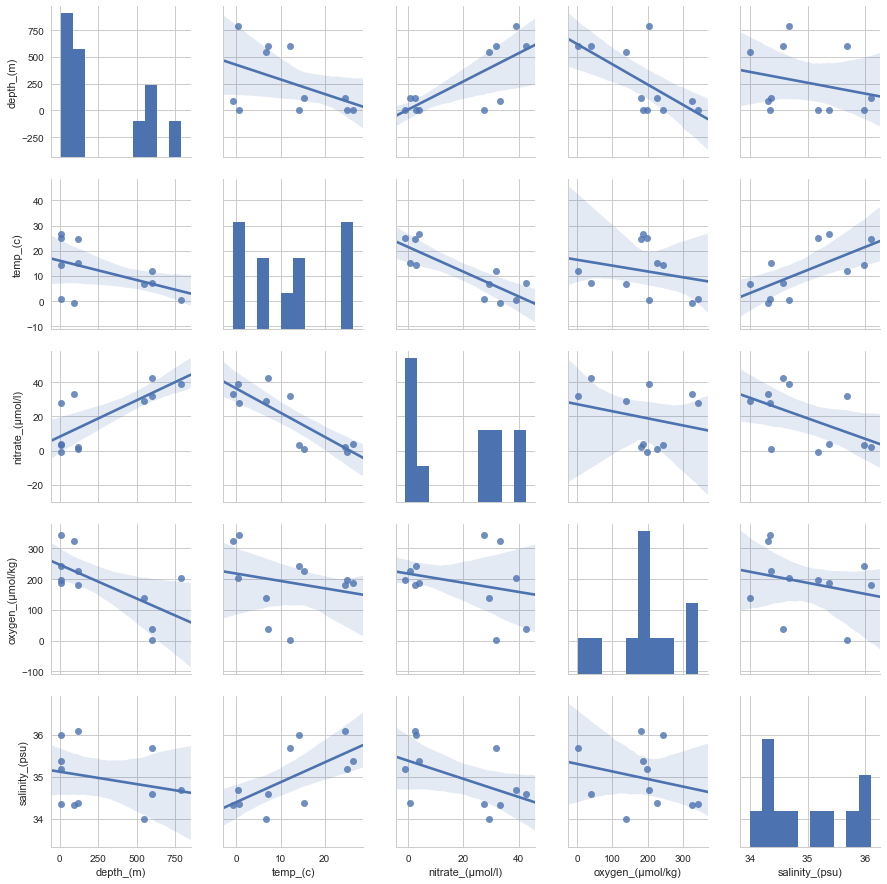

In [15]:
f = sns.pairplot(meta, kind='reg')

f.savefig(
    f'{img_path}pca-pair/pair_reg.png',
    bbox_inches='tight', dpi=250)

In [16]:
meta

,region,zone,depth_(m),temp_(c),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu)
0,SO,DCM,90,-0.781540,33.109231,325.402987,34.319478
1,SO,SURF,5,0.671080,27.501159,343.437300,34.353880
2,SO,MESO,790,0.458830,38.821249,203.839400,34.679960
3,SP,DCM,115,24.696250,2.333576,179.916875,36.097575
4,SP,SURF,5,26.544130,3.986359,186.240700,35.366200
5,SP,MESO,600,7.212238,42.532050,38.115125,34.580675
6,NP,DCM,115,15.284298,0.732507,225.501338,34.369090
7,NP,MESO,550,6.689724,29.094100,138.735952,34.000507
8,NP,SURF,5,25.173925,-0.979589,197.682417,35.181842
9,NA,SURF,5,14.280650,2.999226,243.148000,35.986042


In [17]:
# Calculate r2 values

cols = meta.columns

for i in range(2,7):
    for j in range(i+1, 7):
        
        x = meta.iloc[:,i]
        y = meta.iloc[:,j]

        res = stats.linregress(x,y)
        r2 = res.rvalue**2
        
        print(f'{cols[i]} vs {cols[j]}')
        print(r2)
        print()

depth_(m) vs temp_(c)
0.208499981257

depth_(m) vs nitrate_(µmol/l)
0.55942419733

depth_(m) vs oxygen_(µmol/kg)
0.415822282866

depth_(m) vs salinity_(psu)
0.0594461276464

temp_(c) vs nitrate_(µmol/l)
0.690595303644

temp_(c) vs oxygen_(µmol/kg)
0.0553331974987

temp_(c) vs salinity_(psu)
0.429270175465

nitrate_(µmol/l) vs oxygen_(µmol/kg)
0.0616441904021

nitrate_(µmol/l) vs salinity_(psu)
0.257197160024

oxygen_(µmol/kg) vs salinity_(psu)
0.0643256852815



### Pairplot, with `zone` as hue

In [18]:
meta = meta.drop('depth_(m)', axis=1)

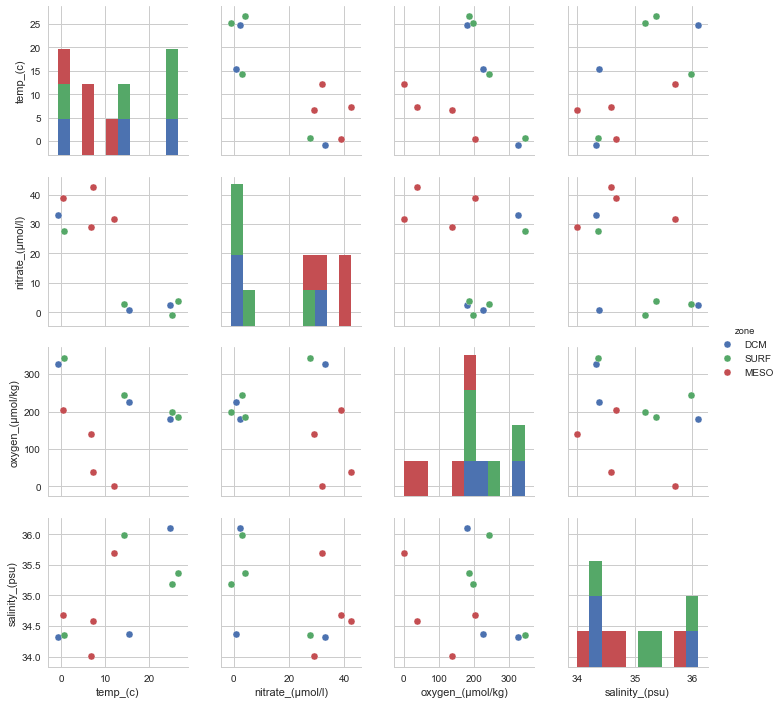

In [19]:
f = sns.pairplot(meta, hue='zone')

f.savefig(
    f'{img_path}pca-pair/pair_zone.png',
    bbox_inches='tight', dpi=250)

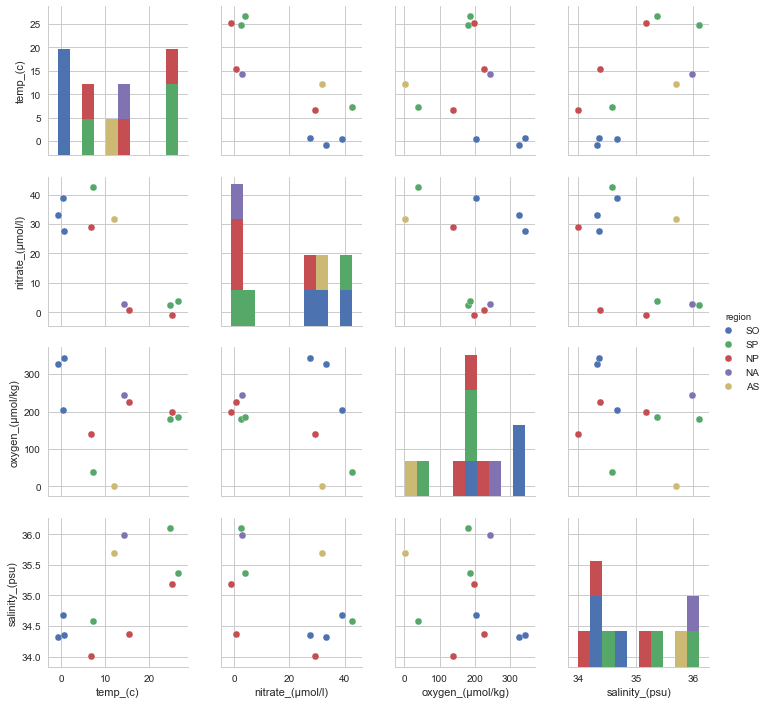

In [20]:
f = sns.pairplot(meta, hue='region')

f.savefig(
    f'{img_path}pca-pair/pair_region.png',
    bbox_inches='tight', dpi=250)

## 3D

In [21]:
# from mpl_toolkits import mplot3d

# pca = PCA(n_components=3)
# projected = pca.fit_transform(data)

# ax = plt.axes(projection='3d')

# x = projected[:,0]
# y = projected[:,1]
# z = projected[:,2]

# ax.scatter3D(x, y, z, c=region_codes)